<h1>Analysis of bus public transport in Malaga using graphs</h1>
<p>Project developed by Jesús Moncada Ramírez for the subject Learning from Networks, University of Padova, 2022-23.</p>

<h1>0. Installation issues</h1>

To run successfully this notebook you must have certain versions of some libraries. This has been discovered by going into bugs and searching on the internet.
<ul>
  <li>Decorator 5.0.9. Discovered in <a href="https://stackoverflow.com/questions/66920533/networkx-shows-random-state-index-is-incorrect">this link</a>.</li>
    <code>pip3 install decorator==5.0.9</code>
</ul> 

<h1>1. Importing the datasets</h1>

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from tabulate import tabulate # To show pandas data frames nicely

%matplotlib inline

In [2]:
df_stops = pd.read_csv('dataset/stops.csv', error_bad_lines=False, usecols=['stop_id','stop_code','stop_name','stop_lat','stop_lon'])
df_stop_times = pd.read_csv('dataset/stop_times.csv', error_bad_lines=False)
df_routes = pd.read_csv('dataset/routes.csv', error_bad_lines=False)
df_trips = pd.read_csv('dataset/trips.csv', error_bad_lines=False)
df_shapes = pd.read_csv('dataset/shapes.csv', error_bad_lines=False)
df_lines_stops = pd.read_csv('dataset/lines_and_stops.csv', error_bad_lines=False, usecols=['codLinea', 'userCodLinea', 'nombreLinea', 'sentido', 'orden', 'codParada', 'nombreParada', 'lon', 'lat'])

In order to translate some column names from Spanish to English, we will apply a <code>rename</code> operation over some of the datasets.

In [3]:
rename_dict = {'codLinea':'line_code', 
               'userCodLinea':'line_label',
               'nombreLinea':'line_name',
               'sentido':'line_direction',
               'orden':'stop_order',
               'codParada':'stop_code',
               'nombreParada':'stop_name',
               'lon':'stop_lon',
               'lat':'stop_lat'}

df_lines_stops.rename(columns = rename_dict, inplace=True)

We can also change the data type of some columns to adjust to the problem we want to solve.

In [4]:
convert_dict = {'line_code':int, 'line_direction':int}

df_lines_stops = df_lines_stops.astype(convert_dict)

Now, let's describe the CSV files imported to discover info about them.

In [5]:
def describe_dataframe(data_name, data, show=5, maxcolw=None, use_tabulate=True):
    """
    Describes a pandas DataFrame
    Arguments:
        data_name: name given to the DataFrame
        data: DataFrame
        show: number of element to show
        maxcol: maximum characters per column
        use_tabulate: true if using tabulate library; false otherwise
    Returns:
        void
    """
    print("--- {0} ---".format(data_name))
    print("Number of elements: {0}".format(len(data)))
    if use_tabulate:
        print(tabulate(data[:show], headers='keys', tablefmt='psql', maxcolwidths=maxcolw))
    else:
        print(data.head(show))

In [6]:
describe_dataframe('STOPS', df_stops)

--- STOPS ---
Number of elements: 1088
+----+-----------+-------------+-------------------------------+------------+------------+
|    |   stop_id |   stop_code | stop_name                     |   stop_lat |   stop_lon |
|----+-----------+-------------+-------------------------------+------------+------------|
|  0 |       103 |         103 | Victoria (Plaza de la Merced) |    36.7234 |   -4.41646 |
|  1 |       104 |         104 | Compás de la Victoria         |    36.7274 |   -4.41355 |
|  2 |       105 |         105 | Fernando el Católico          |    36.729  |   -4.41371 |
|  3 |       106 |         106 | Cristo de la Epidemia         |    36.731  |   -4.41507 |
|  4 |       107 |         107 | Plaza de Fuente Olletas       |    36.733  |   -4.41638 |
+----+-----------+-------------+-------------------------------+------------+------------+


In [7]:
describe_dataframe('STOP_TIMES', df_stop_times)

--- STOP_TIMES ---
Number of elements: 226398
+----+-----------+----------------+------------------+-----------+-----------------+
|    | trip_id   | arrival_time   | departure_time   |   stop_id |   stop_sequence |
|----+-----------+----------------+------------------+-----------+-----------------|
|  0 | 10L7S1V19 | 24:37:00       | 24:37:00         |       755 |              35 |
|  1 | 10L7S1V19 | 24:35:00       | 24:35:00         |       710 |              34 |
|  2 | 10L7S1V19 | 24:34:00       | 24:34:00         |       608 |              33 |
|  3 | 10L7S1V19 | 24:33:00       | 24:33:00         |       709 |              32 |
|  4 | 10L7S1V19 | 24:32:00       | 24:32:00         |       707 |              31 |
+----+-----------+----------------+------------------+-----------+-----------------+


In [8]:
describe_dataframe('ROUTES', df_routes, maxcolw=20)

--- ROUTES ---
Number of elements: 47
+----+------------+--------------------+---------------------+--------------+----------------------+
|    |   route_id |   route_short_name | route_long_name     |   route_type | route_url            |
|----+------------+--------------------+---------------------+--------------+----------------------|
|  0 |          1 |                  1 | Parque del Sur -    |            3 | http://www.emtmalaga |
|    |            |                    | Alameda Principal - |              | .es/emt-mobile/infor |
|    |            |                    | San Andrés          |              | macionLinea.html?cod |
|    |            |                    |                     |              | Linea=1              |
|  1 |          2 |                  2 | Alameda Principal - |            3 | http://www.emtmalaga |
|    |            |                    | Ciudad Jardín       |              | .es/emt-mobile/infor |
|    |            |                    |             

In [9]:
describe_dataframe('TRIPS', df_trips)

--- TRIPS ---
Number of elements: 8391
+----+------------+--------------+-----------+-----------------+----------------+------------+
|    |   route_id | service_id   | trip_id   | trip_headsign   |   direction_id | shape_id   |
|----+------------+--------------+-----------+-----------------+----------------+------------|
|  0 |          1 | LN           | 0L1S1V1   | San Andrés      |              0 | 1IDA       |
|  1 |          1 | LN           | 0L1S1V2   | Parque del Sur  |              1 | 1VTA       |
|  2 |          1 | LN           | 0L1S1V3   | San Andrés      |              0 | 1IDA       |
|  3 |          1 | LN           | 0L1S1V4   | Parque del Sur  |              1 | 1VTA       |
|  4 |          1 | LN           | 0L1S1V5   | San Andrés      |              0 | 1IDA       |
+----+------------+--------------+-----------+-----------------+----------------+------------+


In [10]:
describe_dataframe('SHAPES', df_shapes)

--- SHAPES ---
Number of elements: 24381
+----+------------+----------------+----------------+---------------------+
|    | shape_id   |   shape_pt_lat |   shape_pt_lon |   shape_pt_sequence |
|----+------------+----------------+----------------+---------------------|
|  0 | 1IDA       |        36.7378 |       -4.42207 |                   0 |
|  1 | 1IDA       |        36.7379 |       -4.42243 |                   1 |
|  2 | 1IDA       |        36.7379 |       -4.42273 |                   2 |
|  3 | 1IDA       |        36.7379 |       -4.42287 |                   3 |
|  4 | 1IDA       |        36.7378 |       -4.42291 |                   4 |
+----+------------+----------------+----------------+---------------------+


In [11]:
describe_dataframe('LINES_STOPS', df_lines_stops, use_tabulate=False)

--- LINES_STOPS ---
Number of elements: 2328
   line_code line_label                                        line_name  \
0          1          1  Parque del Sur - Alameda Principal - San Andrés   
1          1          1  Parque del Sur - Alameda Principal - San Andrés   
2          1          1  Parque del Sur - Alameda Principal - San Andrés   
3          1          1  Parque del Sur - Alameda Principal - San Andrés   
4          1          1  Parque del Sur - Alameda Principal - San Andrés   

   line_direction  stop_order  stop_code                           stop_name  \
0               1           1        152  Av. de las Postas - Lorenza Correa   
1               1           2        153                         Emilio Díaz   
2               1           3        154            San Juan Bosco - Albéniz   
3               1           4        155          San Juan Bosco - Segalerva   
4               1           5       1354             Eduardo Domínguez Ávila   

   stop_lon   sto

<h1>2. Creating the graph</h2>

As there are several inconsistencies in the datasets (e.g. the number of lines in <code>routes.csv</code> is not the same as the number of lines in <code>lines_and_stops.csv</code>) we will use the file <code>lines_and_stops.csv</code> (DataFrame <code>df_lines_stops</code>) to build the graph and the rest of the files for extra information.

We have to create a <b>directed</b> graph (due to the two directions of the bus lines) with <b>multiple</b> edges between two nodes (because of several bus lines connecting the same two stops).

In [12]:
G = nx.MultiDiGraph()

<h2>2.1. Adding the nodes</h2>

First of all, let's add all the nodes (bus stops). Note we get the stops from the <code>df_lines_stops</code> DataFrame, using the DataFrame <code>df_stops</code> to get extra information (stop name, stop URL...).

In [13]:
# Attributes we will include in each node
col_target = ['stop_code', 'stop_name', 'stop_lon', 'stop_lat']

# Get all the stops from df_lines_stops
stops = df_lines_stops.drop_duplicates('stop_code')[col_target]

# Show DataFrame
describe_dataframe('PROCESSED STOPS', stops)

# Add all stops to the graph
for index, stop in stops.iterrows():
    G.add_node(stop['stop_code'], name=stop['stop_name'], lat=stop['stop_lat'], lon=stop['stop_lon'])

--- PROCESSED STOPS ---
Number of elements: 1116
+----+-------------+------------------------------------+------------+------------+
|    |   stop_code | stop_name                          |   stop_lon |   stop_lat |
|----+-------------+------------------------------------+------------+------------|
|  0 |         152 | Av. de las Postas - Lorenza Correa |   -4.42225 |    36.7378 |
|  1 |         153 | Emilio Díaz                        |   -4.42359 |    36.7357 |
|  2 |         154 | San Juan Bosco - Albéniz           |   -4.42232 |    36.734  |
|  3 |         155 | San Juan Bosco - Segalerva         |   -4.42185 |    36.7324 |
|  4 |        1354 | Eduardo Domínguez Ávila            |   -4.4215  |    36.7302 |
+----+-------------+------------------------------------+------------+------------+


Note that the attributes from the DataFrame have been introduced into the graph. This feature, provided by the library NetworkX allows us to get extra information working with the graph object, and also use this information for the metrics and algorithms.

<h2>2.2 Adding the edges</h2>

First, note that every line has an identifier <code>line_code</code> that we will use to identify the lines in our data structures, and a label <code>line_label</code>, which is the formal name of the line, known by every people using public transport. Let's create a dictionary relating every <code>line_code</code> with its <code>line_label</code>.

In [14]:
# Get unique values for line_code
unique_lines = df_lines_stops['line_code'].unique()

# Dictionary: line_code -> line_label
line_code_label_dict = {}

for line in unique_lines:
    line_code_label_dict[line] = df_lines_stops.loc[df_lines_stops["line_code"] == line].iloc[0]["line_label"]

print('Dictionary: line_code->line_label', line_code_label_dict)

Dictionary: line_code->line_label {1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 7: '7', 8: '8', 9: '9', 10: '10', 11: '11', 14: '14', 15: '15', 17: '17', 18: '18', 19: '19', 20: '20', 21: '21', 22: '22', 23: '23', 25: '25', 27: '27', 28: '28', 29: '29', 30: '30', 31: '31', 32: '32', 33: '33', 34: '34', 35: '35', 36: '36', 37: '37', 38: '38', 40: '40', 62: '62', 91: '91', 92: '92', 93: '93', 75: 'A', 71: 'C1', 72: 'C2', 73: 'C3', 76: 'C6', 78: 'C8', 70: 'E', 65: 'L', 41: 'N1', 42: 'N2', 43: 'N3', 44: 'N4', 45: 'N5'}


For example, the line known as C1 (label) has the code 71.

In order to add the edges, we must think of a measure of the connection <b>quality</b> between two stops. It will be an edge attribute (allowed by the library NetworkX) and will be called <code>velocity</code>. If an edge between two stops has a high <code>velocity</code>, it means that the waiting time to get from one stop (origin of the edge) to the other (destination of the edge) is going to be low. In this project we will consider that the <code>velocity</code> attribute for an edge depends on:
<ul>
    <li><b>Distance between stops</b> (inversely proportional): can be computed as the distance between points given as <code>(latitude, longitude)</code>. <i>Notation</i>: distance between stop $s_1$ and stop $s_2$ is: $d(s_1, s_2)$</li>
    <li><b>The number of buses of that line in a time interval</b> (directly proportional): the dataset <code>trips.csv</code> provided us with information about this. They don't specify exactly the time interval (daily, weekly...) of all the trips listed, but this doesn't really matter to us, as we need a high value if a line has high frequency and a low value otherwise. <i>Notation</i>: number of buses of an edge $e$ belonging to a bus line $l$ is $n(l)$</li>
</ul> 
Based on this we define the <code>velocity</code> of an edge $e$, $v(e)$ as:
$$
v(e) = v((s_1, s_2)) = I_v \cdot \frac{n(l)}{d(s_1, s_2)}
$$
where:
<ul>
<li>$e$ belogns to the line $l$ 
<li>$I_v$ is a constant that modulates the importance of the two factors we are considering. In this implementation we will consider $I_v = \frac{1}{1000}$.
</ul>

In [15]:
I_V = 1/1000 # constant

def distance(x1, y1, x2, y2):
    """
    Calculates the distance between two points
    Arguments:
        x1: coordinate x of first point
        x2: coordinate y of first point
        y1: coordinate x of second point
        y2: coordinate y of second point
    Returns:
        distance between the two points
    """
    return np.sqrt((x2-x1)**2 + (y2-y1)**2)

def number_buses(line):
    """
    Gets the number of buses measure for a line
    Arguments:
        line: line_code of the line of which information is wanted
    Returns:
        number of buses measure for a line
    """
    n_buses = len(df_trips.loc[df_trips['route_id'] == line])
    return n_buses if n_buses > 0 else 1

def get_velocity(line, s1, s2):
    """
    Calculates the velocity attribute for two stops in a line
    Arguments:
        line: line_code of the line connecting the two stops
        s1: first stop (DataFrame)
        s2: second stop (DataFrame)
    Returns:
        velocity attribute value
    """
    vel = I_V * float(number_buses(line)) / (distance(s1['stop_lat'], s1['stop_lon'], s2['stop_lat'], s2['stop_lon']))
    return vel

Note that there is no data on the trips for every bus line (for example line with <code>line_id</code> 91). As we have defined the velocity of an edge, if this happens it would have <code>velocity = 0</code>. We don't want this, so if the number of buses returned by our function was 0 it returns 1.

Now we're ready to add all edges to our graph.

In [16]:
for line in unique_lines: # for every line
    for direction in [1, 2]: # for every direction
        
        # Get all the data from df_lines_stops
        data = (df_lines_stops.loc[(df_lines_stops['line_code'] == line) &
                                 (df_lines_stops['line_direction'] == direction)])
        
        #Saving steps to retrieve (lat, lon) of stops
        previous_step = None
        actual_step = None
        
        for index, step in data.iterrows(): # for row in data
            previous_step = actual_step
            actual_step = step
            
            if previous_step is not None and actual_step is not None:
                # Calculate velocity
                vel = get_velocity(line, previous_step, actual_step)
                # Add edge
                G.add_edge(previous_step['stop_code'], actual_step['stop_code'], line=int(line), direction=int(direction), velocity=vel)

print("The graph has {0} edges".format(len(G.edges())))

The graph has 2236 edges


<h3>2.2.1. Analyzing velocities</h3>

Now we should analyze the velocities to discover the range of values that they take.

In [17]:
def stats_velocities(G):
    """
    Prints some statistics about the 'velocity' attribute of a graph edges
    Arguments:
        G: graph
    Returns:
        a list with all the velocity attribute values in the graph
    """
    # Get all velocities as a list
    velocities = []

    for _, _, data in G.edges(data=True):
        velocities.append(data['velocity'])

    # Calculate some statistics
    vel_min = min(velocities)
    vel_max = max(velocities)
    vel_mean = np.mean(velocities)
    vel_std = np.std(velocities)

    print('VELOCITY stats')
    print('\tNumber of values:', len(velocities))
    print('\tMinimum value:', vel_min)
    print('\tMaximum value:', vel_max)
    print('\tMean:', vel_mean)
    print('\tStandard deviation:', vel_std)
    
    return velocities

In [18]:
vels = stats_velocities(G)

VELOCITY stats
	Number of values: 2236
	Minimum value: 0.01989299444260319
	Maximum value: 778.6867146145279
	Mean: 70.95989163774544
	Standard deviation: 73.17717189732548


As we can appreciate, the difference between the maximum value and the mean is very high. This happens because there are several stops of the same line that are geographically very close. We are going to apply <b>saturation</b> at the value of 300. 

In [19]:
THRESHOLD = 300

for _, _, data in G.edges(data=True):
    if data['velocity'] >= THRESHOLD:
        data['velocity'] = THRESHOLD
        
vels = stats_velocities(G);

VELOCITY stats
	Number of values: 2236
	Minimum value: 0.01989299444260319
	Maximum value: 300
	Mean: 70.19246172224311
	Standard deviation: 69.57246045077508


Now we are going to <b>normalize</b> the values (against the maximum), forcing them to take values in the interval <code>[0,1]</code>.

In [20]:
for _, _, data in G.edges(data=True):
    data['velocity'] = float(data['velocity'])/max(vels)
    
vels = stats_velocities(G);

VELOCITY stats
	Number of values: 2236
	Minimum value: 6.630998147534397e-05
	Maximum value: 1.0
	Mean: 0.23397487240747705
	Standard deviation: 0.2319082015025836


<h2>2.3. Displaying it graphically</h2>

First of all, we will have to assign a color to each node (stop) and edge (the connection between stops) in the graph. The color of a stop will be blue, and won't depend on the lines, as a stop can belong to several bus lines. For the edges color we have two options.

The first thing we have to do is create a dictionary with the position of every node, <code>positions</code>.

In [21]:
# Dictionary: node -> [lon, lat]
positions = {}

for stop_line, data in G.nodes(data=True):
    positions[stop_line] = [data['lon'], data['lat']]

<h3>2.3.1. Velocity-based edge color</h3>

One option is to show with a more visible color those edges with a high velocity value. Those edges with a low velocity value will have an almost white color, in this way we get the grayscale in our graph drawing.

In [22]:
# One cell for every edge color
edge_color_vel = []

for u, v, data in G.edges(data=True):
    edge_color_vel.append([1-data['velocity'],1-data['velocity'],1-data['velocity']])

To display all nodes in the graph we execute:

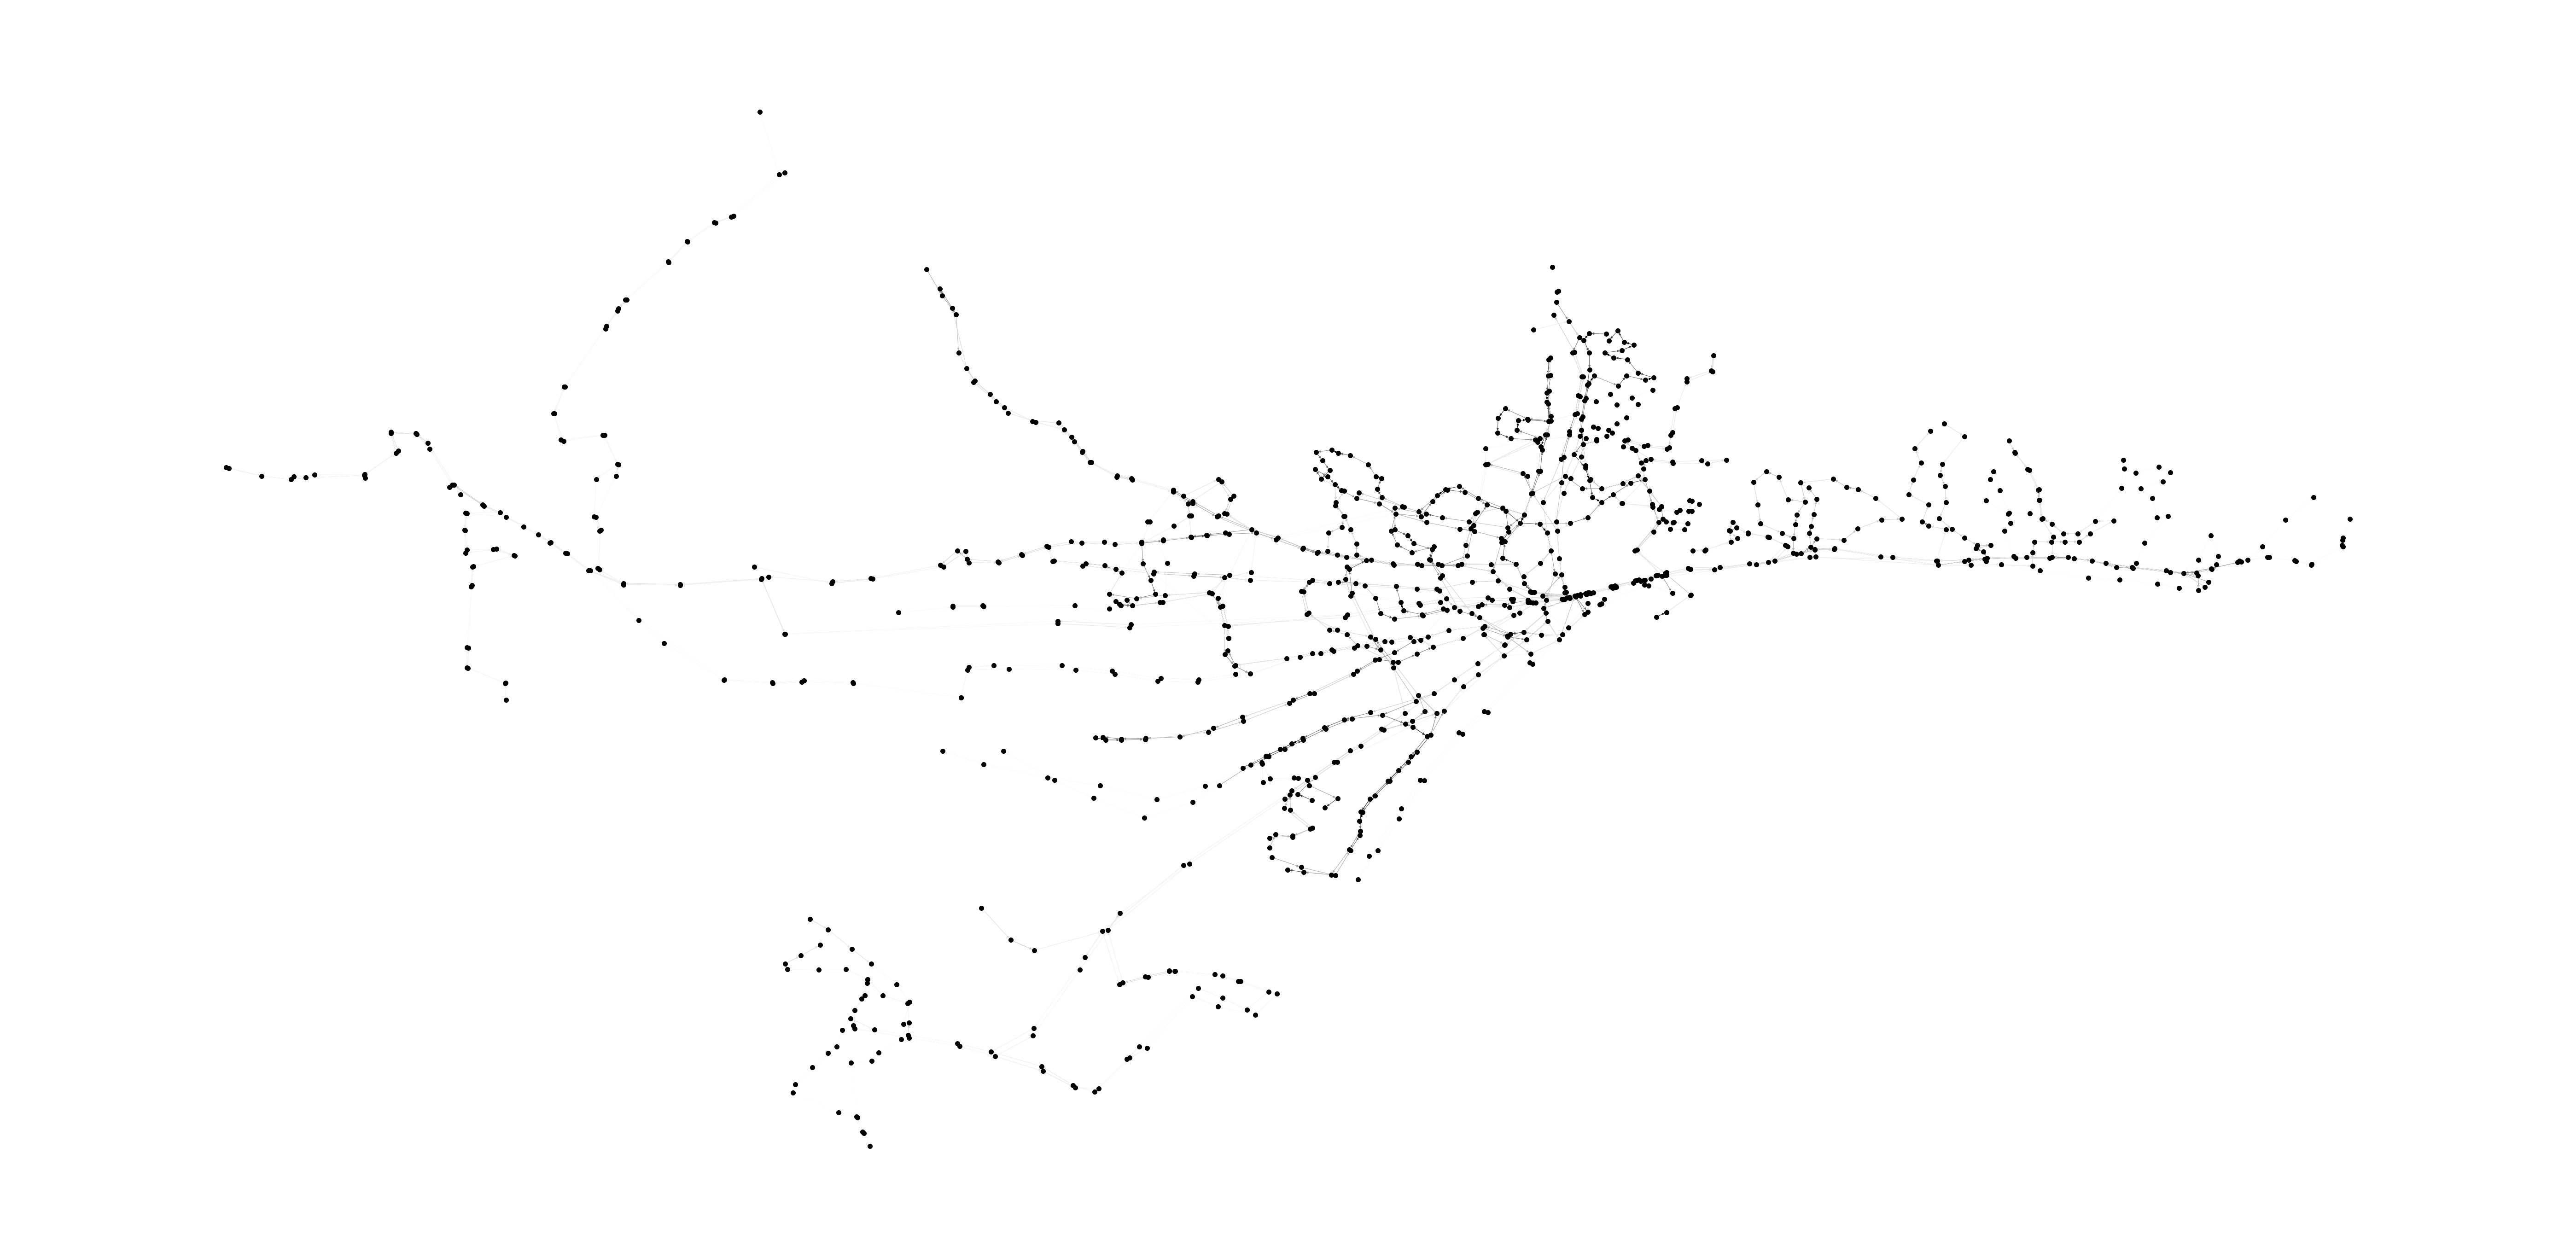

In [23]:
fig, ax = plt.subplots(figsize = (100,50))

nx.draw(G,
        pos         = positions,
        node_color = 'black',
        edge_color = edge_color_vel,
        font_size   = 10,
        node_size   = 100)

fig.savefig("drawings/velocity_based.png")

<h3>2.3.2. Line-based edge color</h3>

Another option consists in each line having a color, so the edges belonging to this line will be all of the same color. These colors are going to be chosen at random.

In [24]:
# Dictionary: line -> color [R, G, B]
line_color_dict = {}

# Assign a random color to each line
for line in unique_lines:
    line_color_dict[line] = tuple(np.random.random(3))

# One cell for every edge color
edge_color_ln = []

for u, v, data in G.edges(data=True):
    edge_color_ln.append(line_color_dict[data['line']])

To display all the nodes in the graph we execute:

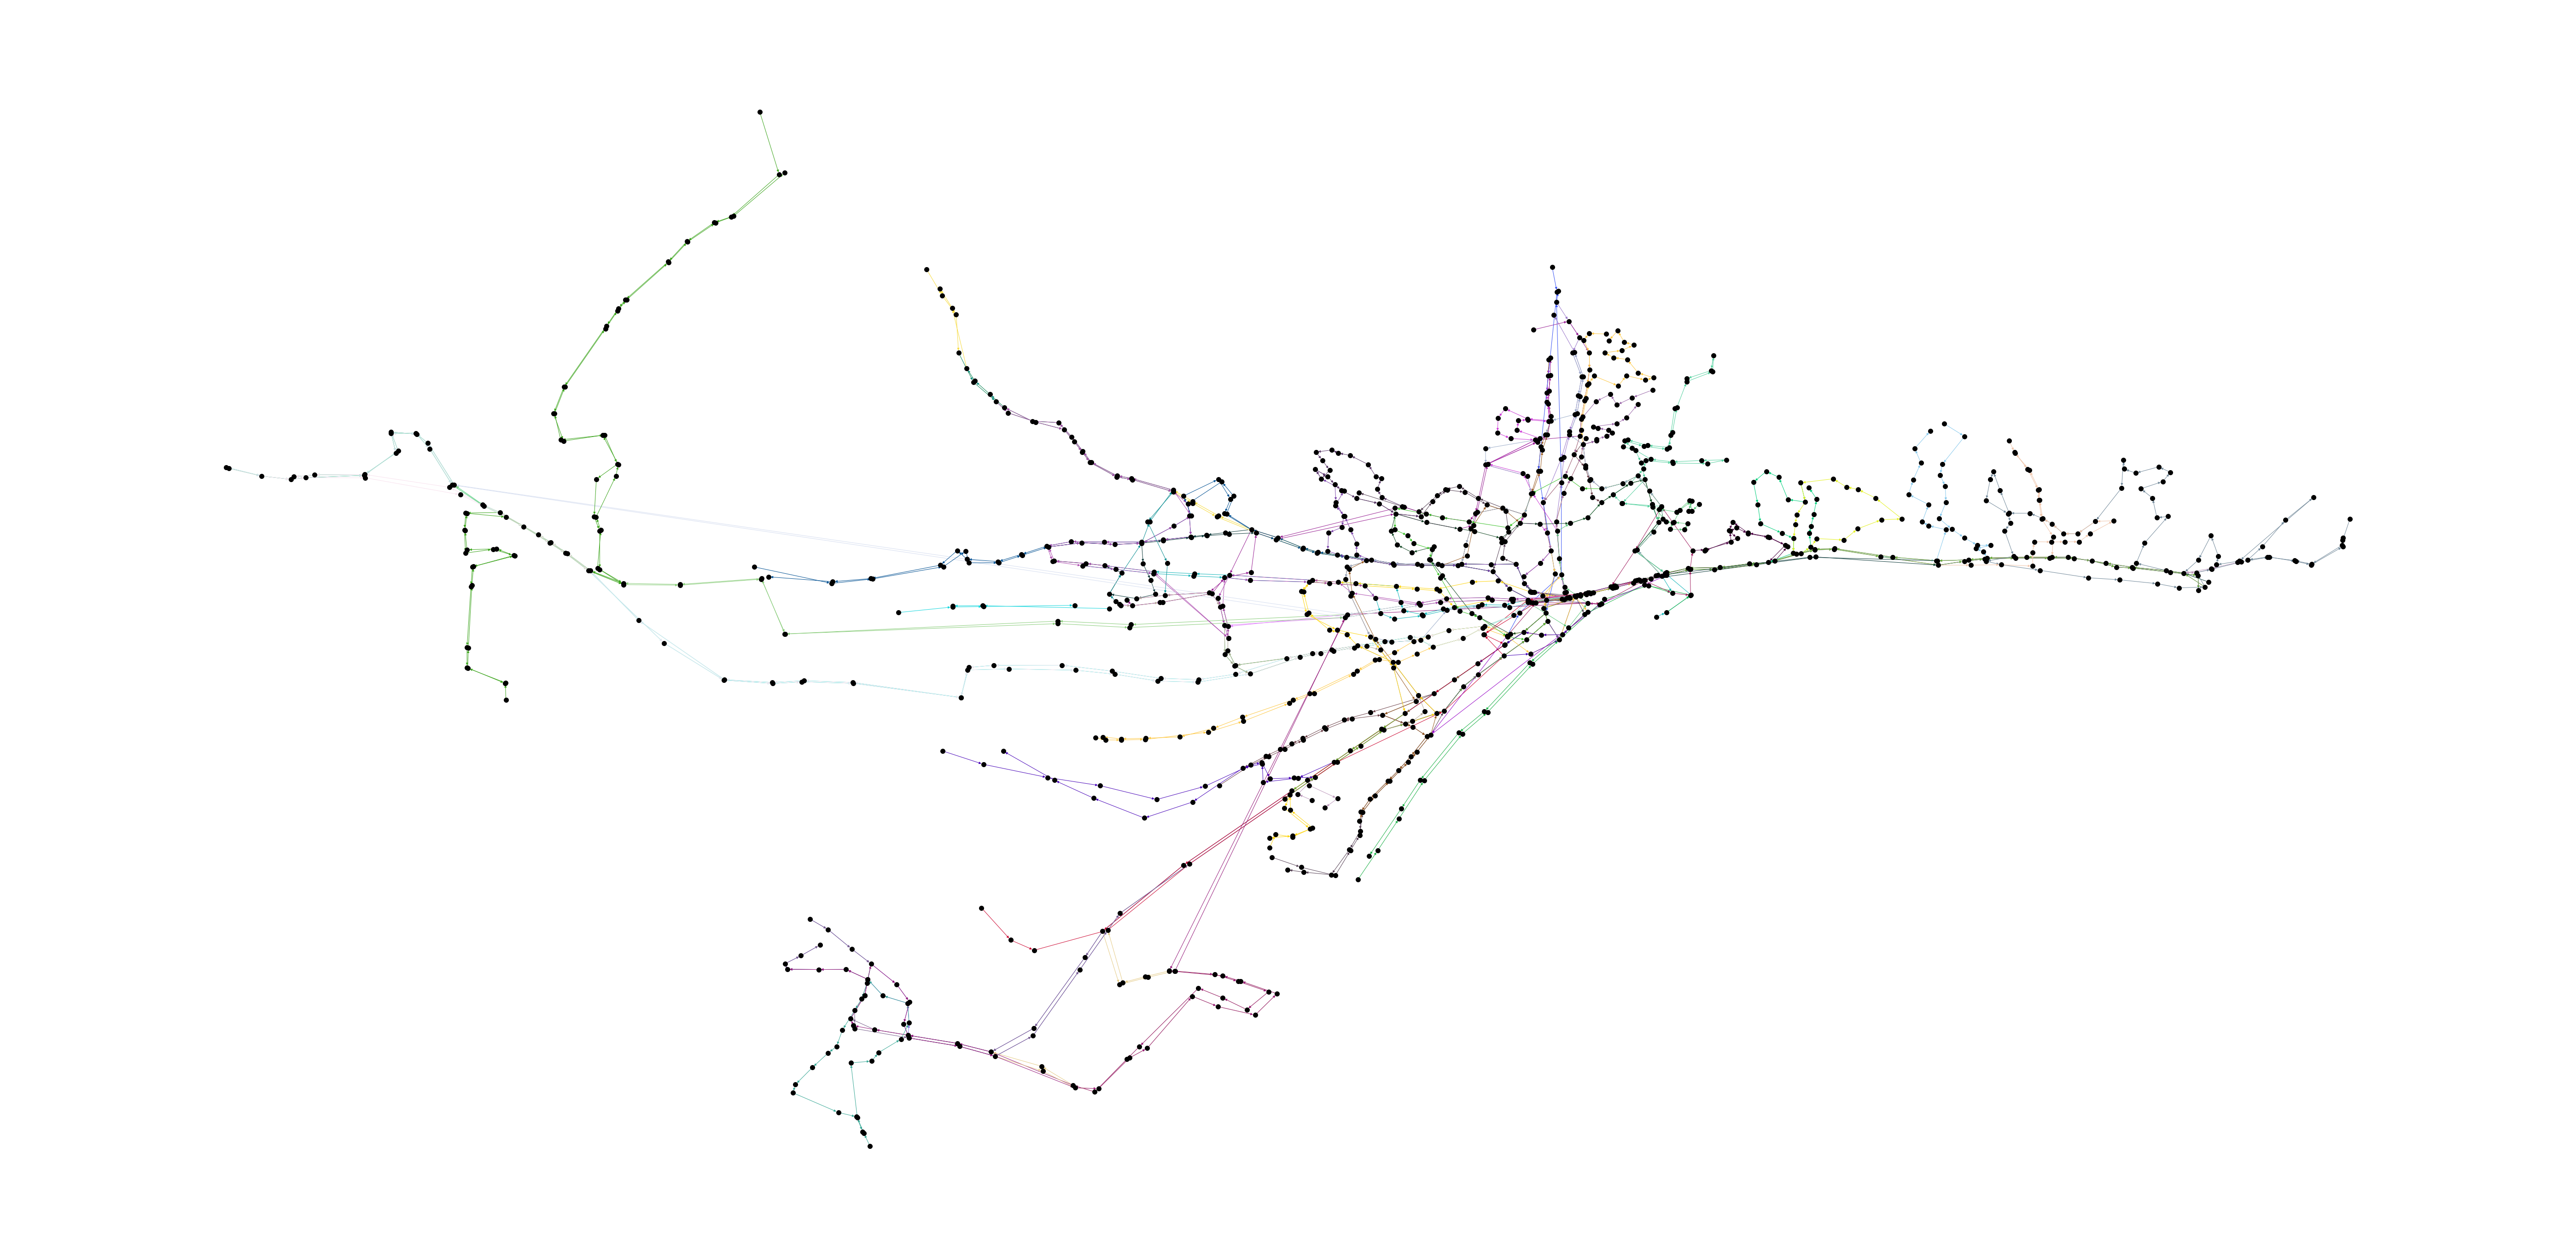

In [25]:
fig, ax = plt.subplots(figsize = (100,50))

nx.draw(G,
        pos         = positions,
        node_color = 'black',
        edge_color = edge_color_ln,
        font_size   = 10,
        node_size   = 100)

fig.savefig("drawings/line_based.png")

<h3>2.3.3. Using Mplleaflet (optional)</h3>

The Python library Mplleaflet allows showing Matplotlib drawings on an interactive map based on Open Street Map and other map services. The result is a webpage, which can be embedded into a Jupyter Notebook.

Unfortunately, there are bugs in the library that haven't been solved yet, like <a href="https://stackoverflow.com/questions/60603427/problems-plotting-on-mplleaflet-using-networkx-and-python">the one</a> that I encountered during the development of the project. To solve it I had to downgrade Matplotlib to version 3.3.2 (<a href="https://lightrun.com/answers/jwass-mplleaflet-_gridonmajor-bug-with-recent-versions-of-matplotlib">following this link</a>) and edit the source code of the <code>Mplleaflet</code> library. Specifically, the file <code>mplleaflet/utils.py</code> by substituting the line:

<code>elif code == 'L':</code>

by:

<code>elif code == 'L' or code == 'S' or code == 'Z':</code>

Even so, the results aren't as good as expected. Executing the cells of code below you can observe that the edges of the graph appear lightly moved with respect to their original position (in the previous image). Because of that, this section has been classified as optional, like an extended feature that can be computed to test.

In [26]:
#import mplleaflet

In [27]:
#mplleaflet.show(fig = ax.figure, path='drawings/generated_map.html')

<h1>3. Node centralities</h1>

Our analysis will be centered on the computation of some node centralities for nodes (stops). 

In this section we are going to create another version of our graph (<code>G_closeness</code>) with only one difference: instead of having the value of <code>velocity</code> we will have its inverse which will be called <code>distance</code>. With this, if an edge had a high <code>velocity</code> value, it means that it was very fast, so its <code>distance</code> will be low (inverse). The same for the opposite case.

In [28]:
def velocity_to_distance(G):
    """
    Creates a copy of a graph changing the 'velocity' attribute to 
    the 'distance' attribute
    Arguments:
        G: graph to be changed
    Returns:
        a copy of the original graph with every edge attribute 'velocity'
        transformed into 'distance'
    """
    # Copy the graph
    G_ret = G.copy()

    # Change 'velocity' attribute to 'distance' as we have explained
    for _, _, data in G_ret.edges(data=True):
        data['distance'] = 1/data['velocity'] # calculate distance
        data.pop('velocity') # delete velocity
        
    return G_ret

In [29]:
# Let's create the new graph
G_closeness = velocity_to_distance(G)
    
print("The graph has {0} edges".format(len(G_closeness.edges())))

The graph has 2236 edges


<h2>3.1. Closeness centrality</h2>

In this section, we will consider two versions of closeness centrality. The first one does not take into account the <code>distance</code> attribute of each edge we have calculated, so supposes that each edge is weighted with a value of 1. The second version takes into account this attribute. We will report the best and worst nodes related to this centrality measure and compare them.

<h3>3.1.1. Without considering <code>distance</code></h3>

The documentation read to calculate all the centralities using the library can be found [here](https://networkx.org/documentation/networkx-1.10/reference/generated/networkx.algorithms.centrality.closeness_centrality.html).

In [30]:
# Closeness centrality for all nodes in our graph
cn_cen = nx.closeness_centrality(G_closeness)

In [31]:
best_node = max(cn_cen, key=cn_cen.get)

print('The node with the highest CLOSENESS CENTRALITY is', best_node)
describe_dataframe('HIGHEST CLOSENESS CENTRALITY', df_stops.loc[df_stops['stop_id'] == best_node])

The node with the highest CLOSENESS CENTRALITY is 164
--- HIGHEST CLOSENESS CENTRALITY ---
Number of elements: 1
+----+-----------+-------------+------------------+------------+------------+
|    |   stop_id |   stop_code | stop_name        |   stop_lat |   stop_lon |
|----+-----------+-------------+------------------+------------+------------|
| 25 |       164 |         164 | Paseo del Parque |    36.7195 |   -4.41627 |
+----+-----------+-------------+------------------+------------+------------+


As we expected, the stop with the <b>highest closeness centrality</b> value is located in the city center. "Paseo del Parque" avenue in Málaga is one of the busiest and has connections with most of the city's bus lines.

As we can observe there are several nodes with closeness centrality equals to 0, this is because NetworkX approximates really small numbers to 0. Let's visualize these stops.

In [32]:
worst_nodes = []
for stop_id in cn_cen:
    if cn_cen[stop_id] == 0:
        worst_nodes.append(stop_id)

print('The node with the lowest CLOSENESS CENTRALITY are: ')
describe_dataframe('LOWEST CLOSENESS CENTRALITY', df_stops.loc[df_stops['stop_id'].isin(worst_nodes)][['stop_id', 'stop_name']])

The node with the lowest CLOSENESS CENTRALITY are: 
--- LOWEST CLOSENESS CENTRALITY ---
Number of elements: 46
+----+-----------+-----------------------------------------------+
|    |   stop_id | stop_name                                     |
|----+-----------+-----------------------------------------------|
| 14 |       152 | Avda. de las Postas (Lorenza Correa)          |
| 28 |       172 | Hermanos Lumiere                              |
| 41 |       229 | Atarazanas                                    |
| 76 |       351 | Puerta Blanca (Gregorio Diego)                |
| 91 |       401 | Paseo del Parque (Plaza del General Torrijos) |
+----+-----------+-----------------------------------------------+


Analyzing the stops with the <b>lowest closeness centrality</b> we have discovered that they are located in remote parts of the city, and they are usually the first/last stops of a line. For example, stop 152 (<i>Avda. de las Postas (Lorenza Correa)</i>) is the first/last of line 1; and stop 351 (<i>Puerta Blanca (Gregorio Diego)</i>) is the first/last of line 3.

<h3>3.1.2. Considering <code>distance</code></h3>

In [33]:
# Closeness centrality for all nodes in our graph
cn_cen_distance = nx.closeness_centrality(G_closeness, distance='distance')

In [34]:
best_node = max(cn_cen_distance, key=cn_cen_distance.get)

print('The node with the highest CLOSENESS CENTRALITY is', best_node)
describe_dataframe('HIGHEST CLOSENESS CENTRALITY', df_stops.loc[df_stops['stop_id'] == best_node], maxcolw=30)

The node with the highest CLOSENESS CENTRALITY is 1359
--- HIGHEST CLOSENESS CENTRALITY ---
Number of elements: 1
+-----+-----------+-------------+-------------------------+------------+------------+
|     |   stop_id |   stop_code | stop_name               |   stop_lat |   stop_lon |
|-----+-----------+-------------+-------------------------+------------+------------|
| 417 |      1359 |        1359 | Paseo de la Farola      |    36.7178 |   -4.41245 |
|     |           |             | (Comandancia de Marina) |            |            |
+-----+-----------+-------------+-------------------------+------------+------------+


In [35]:
worst_nodes = []
for stop_id in cn_cen_distance:
    if cn_cen_distance[stop_id] == 0:
        worst_nodes.append(stop_id)

print('The node with the lowest CLOSENESS CENTRALITY are: ')
describe_dataframe('LOWEST CLOSENESS CENTRALITY', df_stops.loc[df_stops['stop_id'].isin(worst_nodes)][['stop_id', 'stop_name']])

The node with the lowest CLOSENESS CENTRALITY are: 
--- LOWEST CLOSENESS CENTRALITY ---
Number of elements: 46
+----+-----------+-----------------------------------------------+
|    |   stop_id | stop_name                                     |
|----+-----------+-----------------------------------------------|
| 14 |       152 | Avda. de las Postas (Lorenza Correa)          |
| 28 |       172 | Hermanos Lumiere                              |
| 41 |       229 | Atarazanas                                    |
| 76 |       351 | Puerta Blanca (Gregorio Diego)                |
| 91 |       401 | Paseo del Parque (Plaza del General Torrijos) |
+----+-----------+-----------------------------------------------+


As we can observe, the stop with the <b>highest closeness centrality</b> changes, now it is stop 417 (<i>Paseo de la Farola (Comandancia de Marina)</i>). This stop is not an important one as it provides only lines 14, 40, and 92. By contrast, it is the more central one, because is located in the middle of the city (not the city center), between the west and east part of Málaga. The stops with the <b>lowest closeness centrality</b> are the same.

<h2>3.2. Betweenness centrality</h2>

Unfortunately, the betweenness centrality algorithm in NetworkX is not implemented for multi-directed graphs. The only solution we have come up with is creating a different version of the graph (called <code>G_betweenness</code>) using a directed graph (no multiple edges between nodes). This way all the edges that were present between two nodes will be substituted by only one. The new <code>velocity</code>  of this edge will be the maximum of the previous ones. The <code>line</code> attribute will be <code>-1</code> and the <code>direction</code> attribute will also be -1, as they don't provide useful information. After this, we will also convert the <code>velocity</code> attribute into the <code>distance</code> one.

In [36]:
def multidi_to_di_max(G):
    """
    Converts a multi-directed graph into a directed-graph. 
    As new attributes it uses the MAXIMUM value for 'velocity'
    and sets 'line' and 'direction' to -1
    Arguments:
        G: graph to be changed
    Returns:
        a directed version of the input graph, with the changes 
        explained
    """
    # Copy the graph
    G_result = nx.DiGraph()

    # For every edge in the input graph
    for u, v, _ in G.edges(data=True):
        
        # If this edge has not been added to the new graph yet
        if not G_result.has_edge(u, v):
            line = -1
            direction = -1
            velocity = 0.0
            
            # For every edge in the input graph
            for um, vm, datam in G.edges(data=True):
                if datam['velocity'] > velocity:
                    velocity = datam['velocity']
            
            # Add the edge to the result graph
            G_result.add_edge(u, v, line=line, direction=direction, velocity=velocity)
    
    return G_result

In [37]:
G_betweenness = multidi_to_di_max(G)
G_betweenness = velocity_to_distance(G_betweenness)    

print("The graph has {0} edges".format(len(G_betweenness.edges())))

The graph has 1277 edges


As before we will consider a version without having into account the <code>distance</code> attribute and another one that considers it.

<h3>3.2.1. Without considering <code>distance</code></h3> 

In [38]:
# Betweenness centrality for all nodes in our graph
bn_cen = nx.betweenness_centrality(G_betweenness, seed=1)

In [39]:
best_node = max(bn_cen, key=bn_cen.get)

print('The node with the highest BETWEENNESS CENTRALITY is', best_node)
describe_dataframe('HIGHEST BETWEENNESS CENTRALITY', df_stops.loc[df_stops['stop_id'] == best_node])

The node with the highest BETWEENNESS CENTRALITY is 662
--- HIGHEST BETWEENNESS CENTRALITY ---
Number of elements: 1
+-----+-----------+-------------+--------------------+------------+------------+
|     |   stop_id |   stop_code | stop_name          |   stop_lat |   stop_lon |
|-----+-----------+-------------+--------------------+------------+------------|
| 171 |       662 |         662 | Avda. de Andalucía |    36.7164 |   -4.42826 |
+-----+-----------+-------------+--------------------+------------+------------+


The stop with the <b>highest betweenness centrality</b> has id 662 (<i>Avda. de Andalucía</i>). This makes sense because lines 4, 7, 8, 14, 19, 21, 23, 38, 92, A, N2, and N3 go through this stop. This information was obtained by looking for this stop in the <a href="https://www.emtmalaga.es/es/descargaapp">EMT app</a>, but can also be obtained with our code.

In [40]:
def lines_of_stop(stop_id, G):
    """
    Gets the line_code of all the lines present in a stop, in a graph
    Arguments:
        stop_id: id of the stop to get the lines
        G: graph
    Returns:
        list of the lines (line_code) that go through the stop
    """
    lines = set()
    
    for s1, s2, data in G.edges(data=True): # for every edge in the graph
        if stop_id == s1 or stop_id == s2:
            lines.add(data['line'])
            
    return list(lines)

In [41]:
linecodes_662 = lines_of_stop(662, G)
print('Line codes of stop 662:', linecodes_662)

# Translate line_code to line_label using the created dictionary
linelabels_662 = []
for code in linecodes_662:
    linelabels_662.append(line_code_label_dict[code])
                                               
print('Line labels of stop 662:', linelabels_662)

Line codes of stop 662: [4, 38, 7, 8, 42, 43, 75, 14, 19, 21, 23, 92]
Line labels of stop 662: ['4', '38', '7', '8', 'N2', 'N3', 'A', '14', '19', '21', '23', '92']


Now let's analyze the stops with the worst betweenness centrality.

In [42]:
worst_nodes = []
for stop_id in bn_cen:
    if bn_cen[stop_id] == 0:
        worst_nodes.append(stop_id)

print('The node with the lowest BETWEENNESS CENTRALITY are (showing only 5): ')
describe_dataframe('LOWEST CLOSENESS CENTRALITY', df_stops.loc[df_stops['stop_id'].isin(worst_nodes)][['stop_id', 'stop_name']])

The node with the lowest BETWEENNESS CENTRALITY are (showing only 5): 
--- LOWEST CLOSENESS CENTRALITY ---
Number of elements: 77
+----+-----------+--------------------------------------+
|    |   stop_id | stop_name                            |
|----+-----------+--------------------------------------|
| 14 |       152 | Avda. de las Postas (Lorenza Correa) |
| 28 |       172 | Hermanos Lumiere                     |
| 39 |       214 | Arroyo del Sastre (Limonero)         |
| 41 |       229 | Atarazanas                           |
| 74 |       320 | Avda. Gregorio Diego                 |
+----+-----------+--------------------------------------+


Again, the stops with the <b>lowest betweenness centrality</b> are those at the beginning/end of a line, which is what we expected.

<h3>3.2.2. Considering <code>distance</code></h3>

In [43]:
# Betweenness centrality for all nodes in our graph
bn_cen_distance = nx.betweenness_centrality(G_betweenness, seed=1, weight='distance')

In [44]:
best_node = max(bn_cen_distance, key=bn_cen_distance.get)

print('The node with the highest BETWEENNESS CENTRALITY is', best_node)
describe_dataframe('HIGHEST BETWEENNESS CENTRALITY', df_stops.loc[df_stops['stop_id'] == best_node])

The node with the highest BETWEENNESS CENTRALITY is 662
--- HIGHEST BETWEENNESS CENTRALITY ---
Number of elements: 1
+-----+-----------+-------------+--------------------+------------+------------+
|     |   stop_id |   stop_code | stop_name          |   stop_lat |   stop_lon |
|-----+-----------+-------------+--------------------+------------+------------|
| 171 |       662 |         662 | Avda. de Andalucía |    36.7164 |   -4.42826 |
+-----+-----------+-------------+--------------------+------------+------------+


In [45]:
worst_nodes = []
for stop_id in bn_cen:
    if bn_cen_distance[stop_id] == 0:
        worst_nodes.append(stop_id)

print('The node with the lowest BETWEENNESS CENTRALITY are (showing only 5): ')
describe_dataframe('LOWEST CLOSENESS CENTRALITY', df_stops.loc[df_stops['stop_id'].isin(worst_nodes)][['stop_id', 'stop_name']])

The node with the lowest BETWEENNESS CENTRALITY are (showing only 5): 
--- LOWEST CLOSENESS CENTRALITY ---
Number of elements: 77
+----+-----------+--------------------------------------+
|    |   stop_id | stop_name                            |
|----+-----------+--------------------------------------|
| 14 |       152 | Avda. de las Postas (Lorenza Correa) |
| 28 |       172 | Hermanos Lumiere                     |
| 39 |       214 | Arroyo del Sastre (Limonero)         |
| 41 |       229 | Atarazanas                           |
| 74 |       320 | Avda. Gregorio Diego                 |
+----+-----------+--------------------------------------+


As we can observe, the results are very similar to those obtained without considering the <code>distance</code> attribute.

<h1>4. Random graphs</h1>

In this section, we will generate some random graphs with the same number of nodes as our original graph and calculate closeness centrality and betweenness centrality on them. After this, all the results will be analyzed to see if the measures we got are significant or not. We will also forget about the edge weights (like <code>velocity</code> or <code>distance</code>) because we discovered the results are very similar using them or not. We will also do without the multiple edges between nodes to simplify the process.

In [46]:
def delete_edge_attributes(G, att_list):
    """
    Deletes a list of attributes from all the edges in a graph
    Arguments:
        G: graph
        att_list: list of attributes to be deleted from the 
        graph edges
    Returns:
        a copy of the graph without these edge attributes
    """
    G_result = G.copy()
    
    for _, _, data in G.edges(data=True): # for every edge
        for att in att_list:
            data.pop(att, None)
    
    return G_result

The version of the graph used for this section will be <code>G_random</code>.

In [47]:
G_random = multidi_to_di_max(G)
G_random = delete_edge_attributes(G_random, ['velocity', 'line', 'lat', 'lon'])

print("The graph has {0} edges".format(len(G_random.edges())))

The graph has 1277 edges


<h2>4.1. Chung-Lu model</h2>

In this section we will:
<ol type="1">
    <li>Calculate the closeness centrality and betweenness centrality for all nodes in the new version of our graph <code>G_random</code>.</li>
    <li>Generate a constant number (<code>N_RANDOM_GRAPHS</code>) of graphs following the Chung-Lu model.</li>
    <li>Calculate the closeness centrality and betweenness centrality for all nodes in these graphs.</li>
    <li>Compare results to see if the results for the original graph are significant.</li>
</ol>

Let's calculate the closeness centrality and betweenness centrality in our original graph (1).

In [48]:
# Closeness centrality for the original graph
chunglu_cc_original = nx.closeness_centrality(G_random)

# Betweenness centrality for the original graph
chunglu_bc_original = nx.betweenness_centrality(G_random)

Now let's create a list (<code>chunglu_random_graphs</code>) containing all the random graphs generated (2).

In [49]:
# Number of random graphs to be generated
N_RANDOM_GRAPHS = 50

# Get degree sequence for original graph
original_deg_sequence = [d for n, d in G_random.degree()]

# List of random graphs generated with the Chung-Lu model
chunglu_random_graphs = []

# Generate those random graphs
for i in range(N_RANDOM_GRAPHS):
    new_graph = nx.expected_degree_graph(original_deg_sequence, seed=i, selfloops=False)
    chunglu_random_graphs.append(new_graph)

The next step is to calculate all the closeness and betweenness centralities for every random graph (3).

In [50]:
# List with the closeness centrality result for every random graph.
chunglu_ccs = [nx.closeness_centrality(graph) for graph in chunglu_random_graphs]
print("Calculated all {0} closeness centralities of random graphs".format(len(chunglu_ccs)))

# List with the betweenness centrality result for every random graph.
chunglu_bcs = [nx.betweenness_centrality(graph) for graph in chunglu_random_graphs]
print("Calculated all {0} betweeness centralities of random graphs".format(len(chunglu_bcs)))

Calculated all 50 closeness centralities of random graphs
Calculated all 50 betweeness centralities of random graphs


The comparison (4) between the real values and the random ones will be performed using z-scores and p-values as seen in the lectures.

<h3>4.1.1. Comparison using z-scores</h3>

The first method used will be z-scores.

In [51]:
# Closeness centrality z-score of each node in the graph
chunglu_cc_zscores = []

# i to access closeness centrality in chunglu_ccs results
# node to access closeness centrality in chunglu_cc_original
for i, node in enumerate(G_random.nodes()):
    real_value = chunglu_cc_original[node]
    
    expectation = np.mean([cc[i] for cc in chunglu_ccs])
    std = np.std([cc[i] for cc in chunglu_ccs])
    
    zscore = (real_value - expectation) / std
    
    chunglu_cc_zscores.append(zscore)

# Betweenness centrality z-score of each node in the graph
chunglu_bc_zscores = []

for i, node in enumerate(G_random.nodes()):
    real_value = chunglu_bc_original[node]
    
    expectation = np.mean([bc[i] for bc in chunglu_bcs])
    std = np.std([bc[i] for bc in chunglu_bcs])
    
    zscore = (real_value - expectation) / std
    
    chunglu_bc_zscores.append(zscore)

Now we can define a function similar to <code>stats_velocities</code>, to show some statistics for a list of values.

In [52]:
def stats(data):
    print('\tStats')
    print('\tNumber of values:', len(data))
    print('\tMinimum value:', min(data))
    print('\tMaximum value:', max(data))
    print('\tMean:', np.mean(data))
    print('\tStandard deviation:', np.std(data))

In [53]:
print("CLOSENESS CENTRALITY Z-scores for Chung-Lu model")
stats(chunglu_cc_zscores)

print("BETWEENNESS CENTRALITY Z-scores for Chung-Lu model")
stats(chunglu_bc_zscores)

CLOSENESS CENTRALITY Z-scores for Chung-Lu model
	Stats
	Number of values: 1116
	Minimum value: -9.337518155001742
	Maximum value: -0.3607586729539216
	Mean: -2.02751765563604
	Standard deviation: 1.098021326387493
BETWEENNESS CENTRALITY Z-scores for Chung-Lu model
	Stats
	Number of values: 1116
	Minimum value: -1.1558083069664205
	Maximum value: 20.375152866843724
	Mean: 1.4758234068500533
	Standard deviation: 2.678252561331387


As we have studied, the z-scores value measures the number of standard deviations that our measure is far away from expectation. 

As we can observe, in the <b>closeness</b> case the mean of z-scores is -2, which means that "the measures obtained are, on average, 2 standard deviations lower than the expectation". This information is telling us that, in random graphs, the nodes (bus stops) are more connected than in our graph, which actually makes sense. The city structure, with its street map and the organization of buses in lines, makes it impossible to connect two stops that are either on streets with different directions or separated by a block of buildings.

In the <b>betweenness</b> case, the difference is lower, as we obtained a mean z-score of 1.48. Observing these results we can conclude that our values obtained are, on average, "1.48 standard deviations higher than the expectation". This is also meaningful because it suggests that the stops of our graph tend to be more present in paths between nodes than in random graphs, which is actually a characteristic of a good public transport system.

<h3>4.1.2. Comparison using p-values</h3>

As we have studied, p-values are also a good measure of the significance when working with random graphs.

In [54]:
# Closeness centrality p-value (Random >= Real) for each node in the graph
chunglu_cc_pvalues_hieq = []
# Closeness centrality p-value (Random <= Real) for each node in the graph
chunglu_cc_pvalues_loeq = []

for i, node in enumerate(G_random.nodes()):
    real_value = chunglu_cc_original[node]
    
    # Count values higher or equal
    n_higher_equal = len([cc[i] for cc in chunglu_ccs if cc[i] >= real_value])
    # Count values lower or equal
    n_lower_equal = len([cc[i] for cc in chunglu_ccs if cc[i] <= real_value])
    
    chunglu_cc_pvalues_hieq.append(n_higher_equal / N_RANDOM_GRAPHS)
    chunglu_cc_pvalues_loeq.append(n_lower_equal / N_RANDOM_GRAPHS)

# Betweenness centrality p-value (Random >= Real) for each node in the graph
chunglu_bc_pvalues_hieq = []
# Betweenness centrality p-value (Random <= Real) for each node in the graph
chunglu_bc_pvalues_loeq = []

for i, node in enumerate(G_random.nodes()):
    real_value = chunglu_bc_original[node]
    
    n_higher_equal = len([bc[i] for bc in chunglu_bcs if bc[i] >= real_value])
    n_lower_equal = len([bc[i] for bc in chunglu_bcs if bc[i] <= real_value])
    
    chunglu_bc_pvalues_hieq.append(n_higher_equal / N_RANDOM_GRAPHS)
    chunglu_bc_pvalues_loeq.append(n_lower_equal / N_RANDOM_GRAPHS)

Now we can show some statistics about the data obtained.

In [55]:
print('CLOSENESS CENTRALITY P-value (Random >= Real) for Chung-Lu model')
stats(chunglu_cc_pvalues_hieq)
print('CLOSENESS CENTRALITY P-value (Random <= Real) for Chung-Lu model')
stats(chunglu_cc_pvalues_loeq)

print('BETWEENNESS CENTRALITY P-value (Random >= Real) for Chung-Lu model')
stats(chunglu_bc_pvalues_hieq)
print('BETWEENNESS CENTRALITY P-value (Random <= Real) for Chung-Lu model')
stats(chunglu_bc_pvalues_loeq)

CLOSENESS CENTRALITY P-value (Random >= Real) for Chung-Lu model
	Stats
	Number of values: 1116
	Minimum value: 0.46
	Maximum value: 1.0
	Mean: 0.8528673835125449
	Standard deviation: 0.0891096158195357
CLOSENESS CENTRALITY P-value (Random <= Real) for Chung-Lu model
	Stats
	Number of values: 1116
	Minimum value: 0.0
	Maximum value: 0.54
	Mean: 0.1635304659498208
	Standard deviation: 0.09501221372230896
BETWEENNESS CENTRALITY P-value (Random >= Real) for Chung-Lu model
	Stats
	Number of values: 1116
	Minimum value: 0.0
	Maximum value: 1.0
	Mean: 0.28872759856630825
	Standard deviation: 0.2914839568889235
BETWEENNESS CENTRALITY P-value (Random <= Real) for Chung-Lu model
	Stats
	Number of values: 1116
	Minimum value: 0.06
	Maximum value: 1.0
	Mean: 0.7648387096774193
	Standard deviation: 0.21041917323694287


Note that the results are somehow correlated to the obtained when measuring the significance with z-scores. Anyway, they will be commented on in the final report.

<h2>4.2. Given Degree Sequence Model</h2>

In this section we will:
<ol type="1">
    <li>Calculate the closeness centrality and betweenness centrality for all nodes in our graph <code>G_random</code>.</li>
    <li>Generate a constant number (<code>N_RANDOM_GRAPHS</code>) of graphs following the Given degree sequence model.</li>
    <li>Calculate the closeness centrality and betweenness centrality for all nodes in these graphs.</li>
    <li>Compare results to see if the results for the original graph are significant.</li>
</ol>
In this case, all the discoveries will be commented in the final report, as they are part of our final project results.

In [56]:
# Closeness centrality for the original graph (already calculated)
degree_cc_original = chunglu_cc_original

# Betweenness centrality for the original graph (already calculated)
degree_bc_original = chunglu_bc_original

In [57]:
# Number of random graphs to be generated
N_RANDOM_GRAPHS = 50

# Get degree sequence for original graph
original_deg_sequence = [d for n, d in G_random.degree()]

# List of random graphs generated with the Given Degree Sequence model
degree_random_graphs = []

# Generate those random graphs
for i in range(N_RANDOM_GRAPHS):
    new_graph = nx.configuration_model(original_deg_sequence, seed=i)
    degree_random_graphs.append(new_graph)

As we had problems with the betweenness centrality because it is not implemented for the graph type that returns the random graph generator, we will skip its analysis.

In [58]:
# List with the closeness centrality result for every random graph.
degree_ccs = [nx.closeness_centrality(graph) for graph in degree_random_graphs]
print("Calculated all {0} closeness centralities of random graphs".format(len(degree_ccs)))

Calculated all 50 closeness centralities of random graphs


<h3>4.2.1. Comparison using z-scores</h3>

In [59]:
# Closeness centrality z-score of each node in the graph
degree_cc_zscores = []

for i, node in enumerate(G_random.nodes()):
    real_value = degree_cc_original[node]
    
    expectation = np.mean([cc[i] for cc in degree_ccs])
    std = np.std([cc[i] for cc in degree_ccs])
    
    zscore = (real_value - expectation) / std
    
    degree_cc_zscores.append(zscore)

In [60]:
print("CLOSENESS CENTRALITY Z-scores for Given Degree sequence model")
stats(degree_cc_zscores)

CLOSENESS CENTRALITY Z-scores for Given Degree sequence model
	Stats
	Number of values: 1116
	Minimum value: -16.228681031951467
	Maximum value: -1.1128891430290497
	Mean: -4.992194612030568
	Standard deviation: 1.71280528995425


<h3>4.2.2. Comparison using p-values</h3>

In [61]:
# Closeness centrality p-value (Random >= Real) for each node in the graph
degree_cc_pvalues_hieq = []
# Closeness centrality p-value (Random <= Real) for each node in the graph
degree_cc_pvalues_loeq = []

for i, node in enumerate(G_random.nodes()):
    real_value = degree_cc_original[node]
    
    # Compute the two countings
    n_higher_equal = len([cc[i] for cc in degree_ccs if cc[i] >= real_value])
    n_lower_equal = len([cc[i] for cc in degree_ccs if cc[i] <= real_value])
    
    degree_cc_pvalues_hieq.append(n_higher_equal / N_RANDOM_GRAPHS)
    degree_cc_pvalues_loeq.append(n_lower_equal / N_RANDOM_GRAPHS)

In [62]:
print('CLOSENESS CENTRALITY P-value (Random >= Real) for Given Degree Sequence model')
stats(chunglu_cc_pvalues_hieq)
print('CLOSENESS CENTRALITY P-value (Random <= Real) for Given Degree Sequence model')
stats(chunglu_cc_pvalues_loeq)

CLOSENESS CENTRALITY P-value (Random >= Real) for Given Degree Sequence model
	Stats
	Number of values: 1116
	Minimum value: 0.46
	Maximum value: 1.0
	Mean: 0.8528673835125449
	Standard deviation: 0.0891096158195357
CLOSENESS CENTRALITY P-value (Random <= Real) for Given Degree Sequence model
	Stats
	Number of values: 1116
	Minimum value: 0.0
	Maximum value: 0.54
	Mean: 0.1635304659498208
	Standard deviation: 0.09501221372230896
